# Motorica SkillFactory internship test task 2023-12

Задача классификации непрерывных команд от пользователя на основе данных, полученных от оптомиографических датчиков.  

Организатор стажировки: компания Моторика, совместно с SkillFactory.

<h2> Тестовое задание:

Необходимо построить модель распознавания жестов в парадигме обучения с учителем.  
Параметры модели должны быть оптимизированы на предложенных данных для обучения.  
Валидация модели будет произведена на отложенной тестовой выборке.

<h2> Оценка:

В качестве метрики оценки качества решения выбран Mean F-score.

<h2> Формат решения

Формат решения можно посмотреть в файле sample_submission.csv.

<h2> Citation:  

Maksim Balashov. (2023).

Motorica SkillFactory internship test task 2023-12.

Kaggle.
https://kaggle.com/competitions/motorica-skillfactory-internship-test-task-2023-12



In [1]:
!pip install catboost -q
!pip install hyperopt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from functools import partial
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

%matplotlib inline
sns.set_context("talk")

# random state
RS = 1

In [3]:
#В колабе импортируем все необходимые библиотеки
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "10ZleFkZLnHPRcOglQBj-wBqCTRy8zy3i"})
# https://drive.google.com/file/d/10ZleFkZLnHPRcOglQBj-wBqCTRy8zy3i/view?usp=drive_link
download.GetContentFile("X_test.npy")

download = drive.CreateFile({"id": "1WOEmdIW7e62PMkDGRfQiA1C-yhdQABk2"})
# https://drive.google.com/file/d/1WOEmdIW7e62PMkDGRfQiA1C-yhdQABk2/view?usp=drive_link
download.GetContentFile("X_train.npy")

download = drive.CreateFile({"id": "1DqMKJ6uCKUsVbjwI4u5g_14gyZh-V6H8"})
# https://drive.google.com/file/d/1DqMKJ6uCKUsVbjwI4u5g_14gyZh-V6H8/view?usp=sharing
download.GetContentFile("y_train.csv")

download = drive.CreateFile({"id": "1OOX3zC_muycSI6HjMN-gfwXA7xKG_kG7"})
# https://drive.google.com/file/d/1OOX3zC_muycSI6HjMN-gfwXA7xKG_kG7/view?usp=drive_link
download.GetContentFile("sample_submission.csv")

In [4]:
X_train_3d = np.load('./X_train.npy')
X_test_3d = np.load('./X_test.npy')

y_train = pd.read_csv('./y_train.csv')
y_sub = pd.read_csv('./sample_submission.csv')
y_test = y_train.copy()

print(X_train_3d.shape, y_train.shape)
print(X_test_3d.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


In [5]:
y_test.head(3)

,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0


In [6]:
def convert_3d_ndarray_to_dataframe(arr_3d):
    """Функция для преобразования трехмерного массива в двухмерный
    Args:
        arr_3d (3d DataFrame): трехмерный массив Pandas

    Returns:
        DataFrame: Двухмерный массив Pandas
    """
    # Создаем пустой двухмерный DataFrame
    df_2d = pd.DataFrame()

    # Проходимся по каждой плоскости трехмерного массива
    for plane_index in range(arr_3d.shape[2]):
        # Создаем временный двумерный DataFrame для текущей плоскости
        temp_df = pd.DataFrame(arr_3d[:,:,plane_index])

        # Добавляем номер плоскости в качестве префикса к названию столбцов
        temp_df.index = [f'{ind}-{plane_index}' for ind in temp_df.index]

        # Объединяем временный DataFrame с общим трехмерным DataFrame
        df_2d = pd.concat([df_2d, temp_df], axis=0)

    return df_2d

# Преобразуем имеющиеся данные в двухмерный DataFrame
X_train = convert_3d_ndarray_to_dataframe(X_train_3d)
X_test = convert_3d_ndarray_to_dataframe(X_test_3d)

print("Исходный трехмерный numpy.ndarray:")
print(X_train_3d.shape)
print()
print("Преобразованный двухмерный DataFrame:")
print(X_train.shape)

Исходный трехмерный numpy.ndarray:
(323, 40, 100)

Преобразованный двухмерный DataFrame:
(32300, 40)


In [7]:
# сохраним индекс для подготовки файла для Kaggle
X_test_index = X_test.index

In [8]:
X_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0-0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,1877.0,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0
1-0,1019.0,11.0,1361.0,70.0,32.0,1552.0,136.0,25.0,976.0,12.0,...,1856.0,62.0,19.0,1171.0,128.0,28.0,1652.0,27.0,748.0,23.0
2-0,965.0,10.0,1300.0,51.0,33.0,1475.0,131.0,6.0,911.0,10.0,...,1721.0,59.0,18.0,1161.0,128.0,29.0,1639.0,24.0,685.0,32.0


In [9]:
# check for any null entries
print(X_train.isnull().sum().sum())

0


Пропуски в данных отсутствуют

In [10]:
print(f'Количество дубликатов в выборке: {round(((len(X_train)- len(X_train.drop_duplicates()))/X_train.shape[0]*100),2)}%')

Количество дубликатов в выборке: 0.44%


Количество дубликатов небольшое, оставлю как резерв для оптимизации.

# Описание данных и визуализация

`y_train.csv` содержит следующие классы:
  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab";¶

In [11]:
# Преобразуем данные для визуализации
y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split(pat='-',n=1, expand=True).astype(int)
y_train = y_train.pivot(index='sample_id', columns='timestep', values='class')
y_train_index = y_train.index
y_train = y_train.sort_index() # на всякий случай
y_train = y_train.values

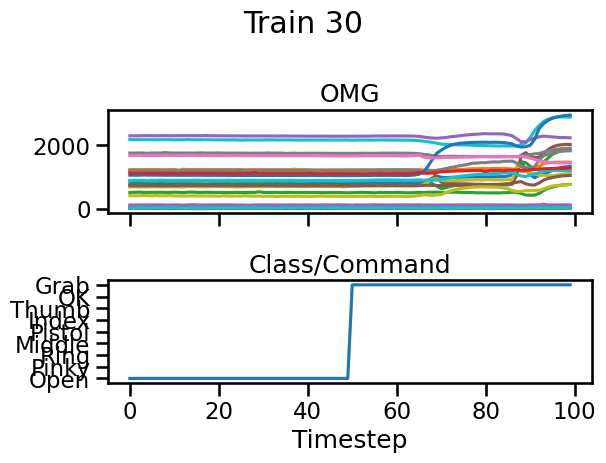

In [12]:
i = 30
fig, axx = plt.subplots(2, 1, sharex=True)

axx[0].plot(X_train_3d[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

Как видно из визуализации, для теста нет целевой переменной.

Это и есть задача хакатона - предсказать, какая команда была выполнена пользователем и в какое время.

In [13]:
X_train.reset_index(drop=False, inplace= True)
X_train[['sample_id', 'time']] = X_train['index'].str.split(pat="-", n=1, expand=True).astype(int)
X_train.sort_values(by=['sample_id', 'time'],inplace=True)
X_train.drop(columns=['sample_id','time','index'], inplace=True)

y_train = pd.read_csv('./y_train.csv')
y_train.drop('sample-timestep', axis =1, inplace = True)
corr_table = X_train.join(y_train)
y_train = y_train.to_numpy()

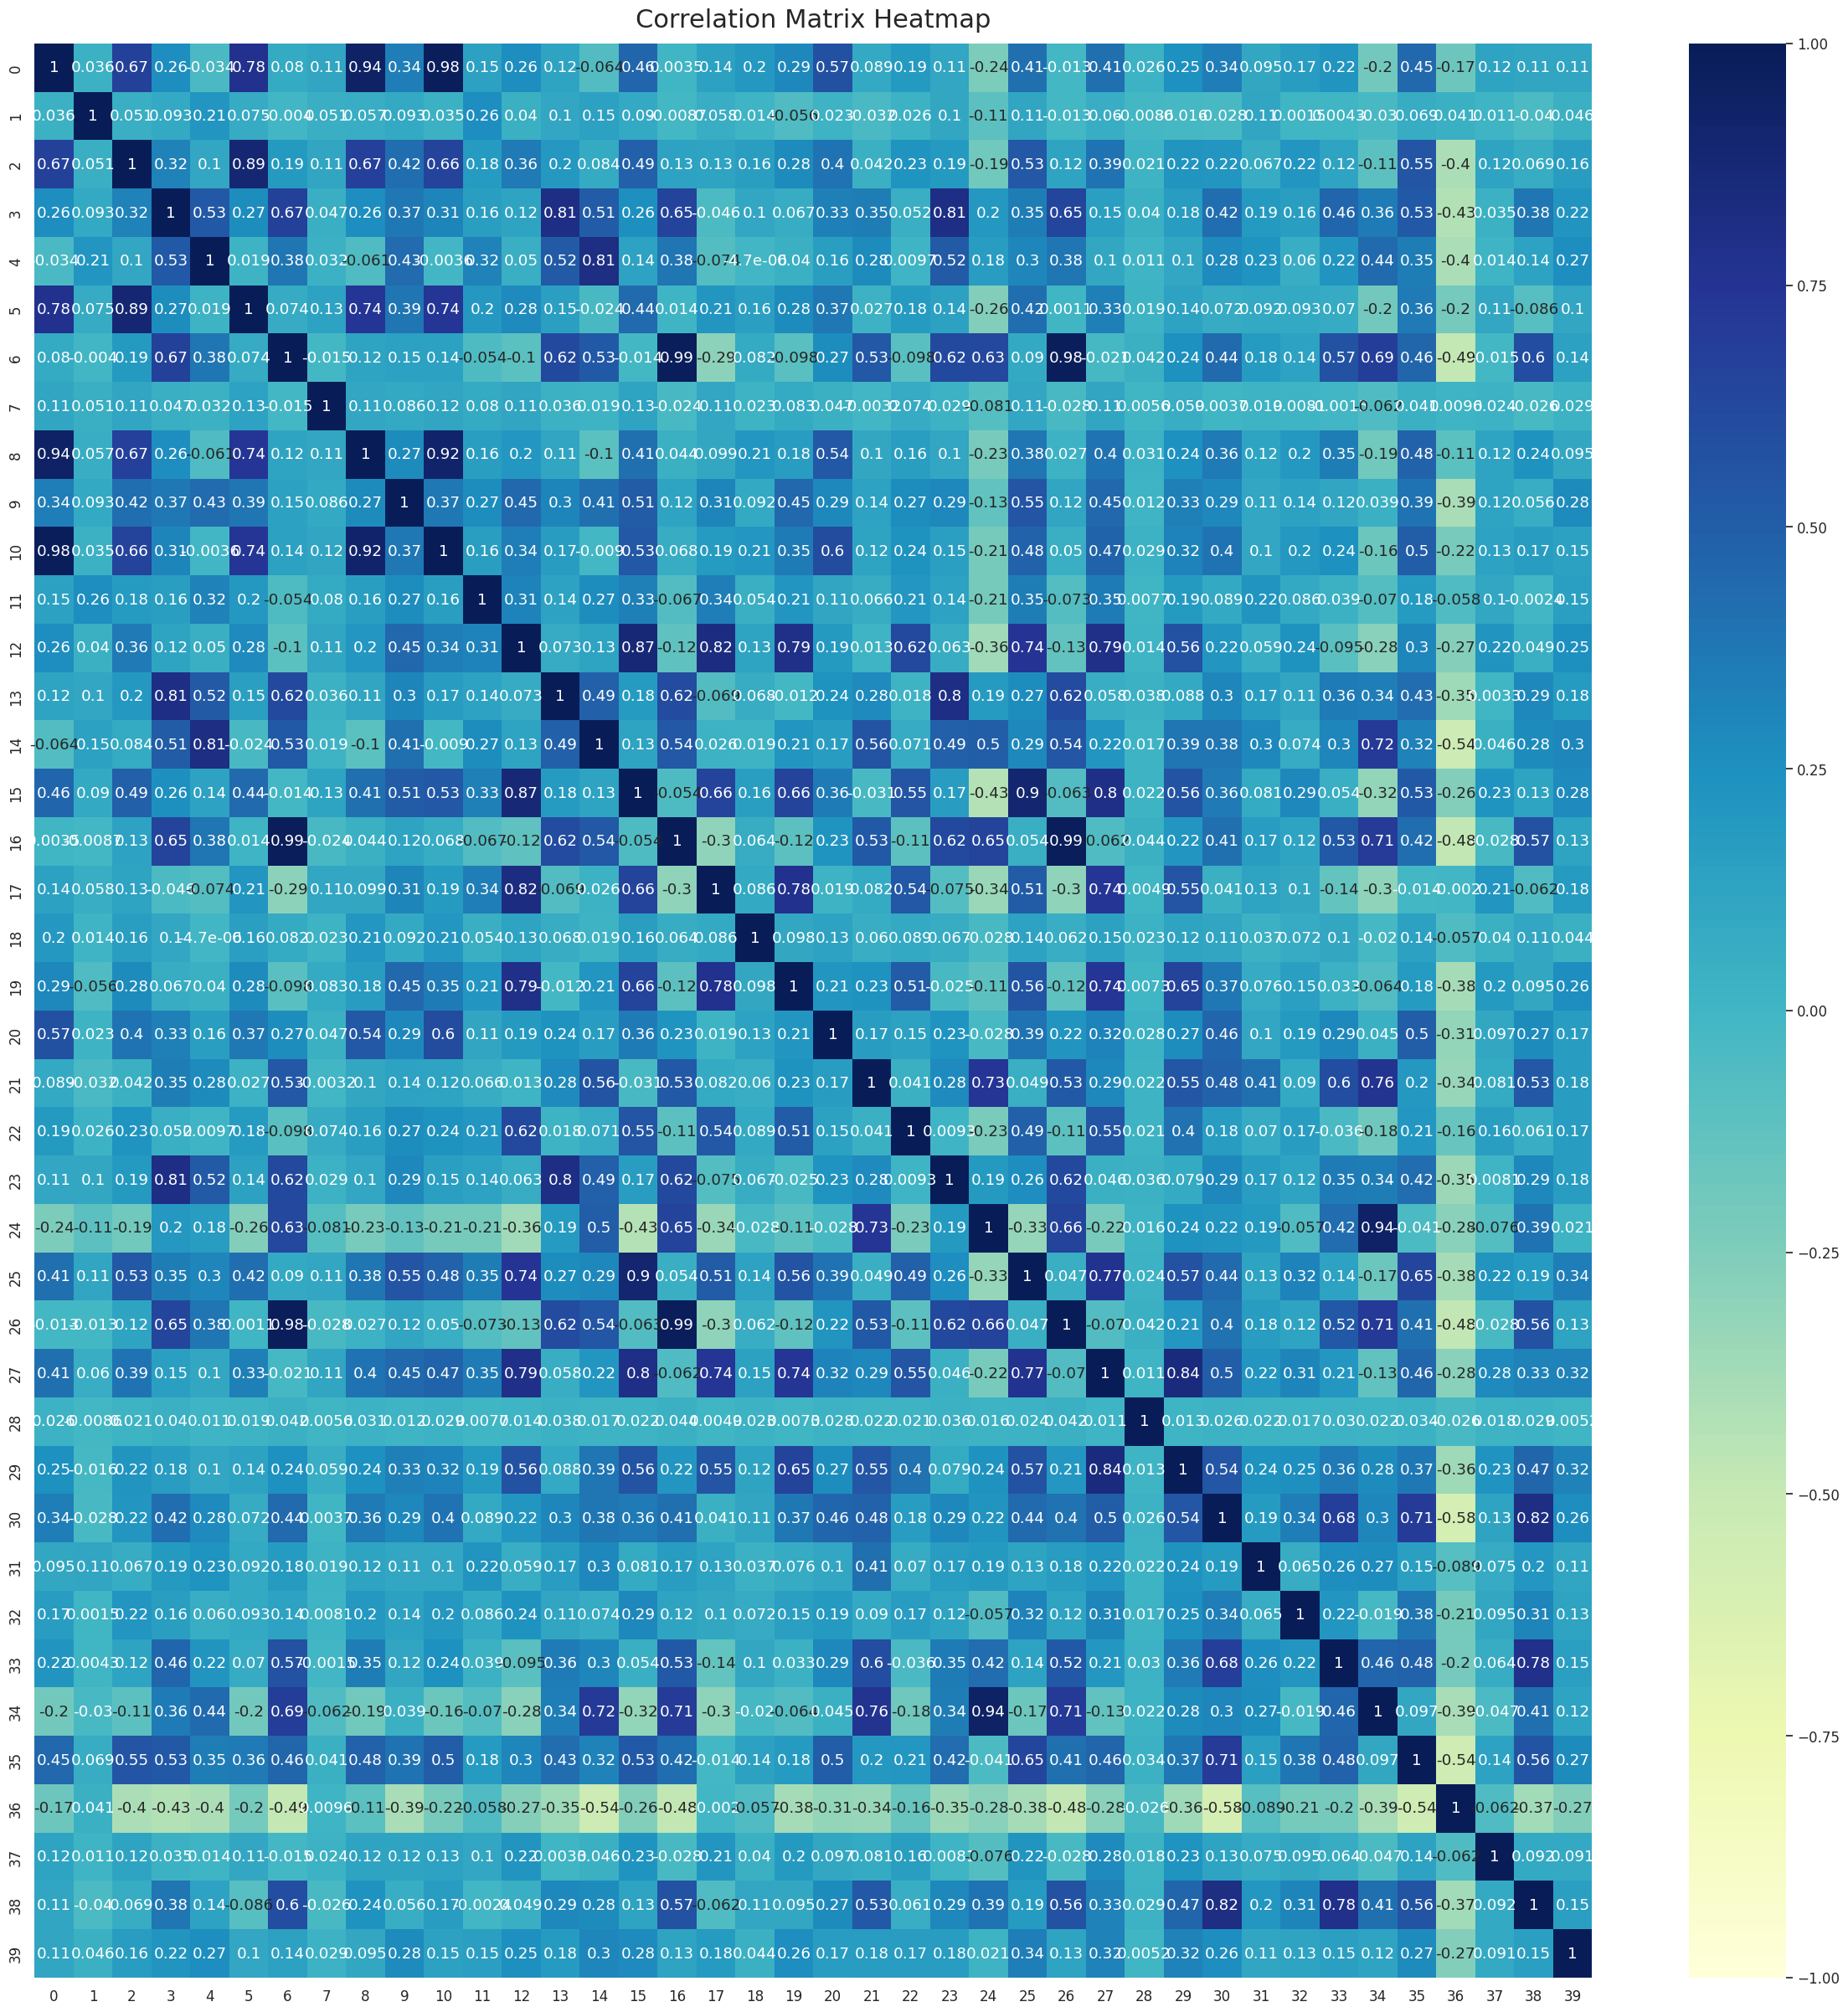

In [14]:
# plot a correlation heat map
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.1)
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")
heatmap.set_title('Correlation Matrix Heatmap', fontdict={'fontsize':22}, pad=14);

Сильная корреляция существует у признаков 0,8,10,6,15,16,24,25,26,34  

In [15]:
corr_table.head(3)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,class
0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0,0
323,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0,6
646,1121.0,17.0,1444.0,60.0,32.0,1732.0,141.0,10.0,1065.0,14.0,...,77.0,14.0,1169.0,130.0,30.0,1670.0,29.0,727.0,27.0,0


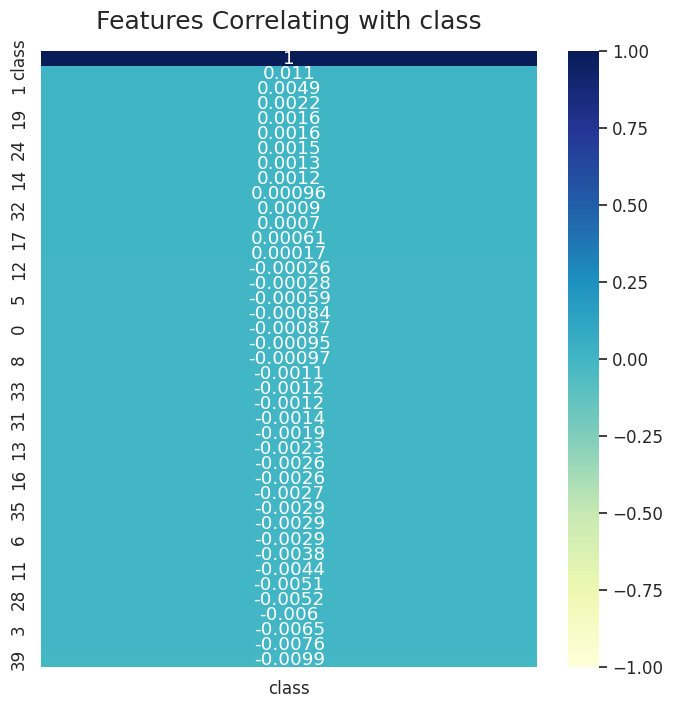

In [16]:
# определим корреляцию признаков с целевым признаком
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(corr_table.corr()[['class']].sort_values(by='class', ascending=False), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")
heatmap.set_title('Features Correlating with class', fontdict={'fontsize':18}, pad=16);

Все признаки имеют достаточно слабую корреляцию с классом, чтобы избавится от корреляции между признаками удалим столбцы 0,6,24,25,26

In [17]:
X_train.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39],
      dtype='object')

In [18]:
X_train.drop(columns=[0,6,24,25,26], inplace=True)

In [19]:
X_train.shape

(32300, 35)

In [20]:
y_train.shape

(32300, 1)

Данные не были проверены на выбросы, т.к. непонятно, что считать выбросами при работе с данными от оптомиографических датчиков, каков их смысл.

Поэтому проведём нормализацию методом устойчивым к выбросам RobustScaler и затем стандартизируем их.

In [21]:
# подготовим тренировочные данные к обучению модели
X_train_c = RobustScaler().fit_transform(X_train)
X_train_c = StandardScaler().fit_transform(X_train_c)

# Создадим модель решения задачи классификации

In [22]:
# определим балансы классов для лучшего предсказания менее представленных в выборке классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=np.ravel(y_train))
class_weights = dict(zip(classes, weights))

In [23]:
# создадим модель
cat_model = CatBoostClassifier(
    # iterations=300, depth=7, learning_rate=0.1,
    loss_function='MultiClass',
    verbose=False,
    class_weights=class_weights,
    task_type="GPU")

# Оптимизируем гиперпараметры

In [24]:
def objective(params, model,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """

    # задаём модели требуемые параметры
    model.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    # проводим кросс-валидацию
    score = cross_val_score(estimator=model, X=X_train_c, y=y_train,
                            scoring="accuracy", cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

In [25]:
search_space = {'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
                'iterations': hp.randint('iterations',100,400),
                'l2_leaf_reg': hp.randint('l2_leaf_reg',1,10),
                'depth': hp.randint('depth',4,7),
                'bootstrap_type' : hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli'])}

In [27]:
trials = Trials()
best = fmin(
          # функция для оптимизации
            fn=partial(objective, model=cat_model, X_train=X_train_c, y_train=y_train),
          # пространство поиска гиперпараметров
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций (можно ещё указать  время поиска)
            max_evals=20,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.default_rng(42),
          # progressbar
            show_progressbar=True
        )

100%|██████████| 20/20 [07:38<00:00, 22.91s/trial, best loss: -0.8843034055727553]


In [28]:
print("Наилучшие значения гиперпараметров {}".format(best))

Наилучшие значения гиперпараметров {'bootstrap_type': 0, 'depth': 6, 'iterations': 282, 'l2_leaf_reg': 2, 'learning_rate': 0.4124351334655566}


## Обучим модель на найденных гиперпараметрах

In [30]:
cat_model = CatBoostClassifier(depth=best['depth'],
                           iterations=best['iterations'],
                           learning_rate = best['learning_rate'],
                           l2_leaf_reg = best['l2_leaf_reg'],
                           bootstrap_type = 'Bayesian',
                           verbose=False,
                           random_seed=RS,
                           loss_function='MultiClass',
                           class_weights=class_weights,
                           task_type="GPU")
cat_model.fit(X = X_train_c, y = y_train)

In [31]:
# сделаем предсказание на обучающей выборке
y_pred_h = cat_model.predict(X_train_c)

# определим метрики
report = classification_report(y_train, y_pred_h)
print("Classification Report:\n", report)

# определим метрики
# f1 = f1_score(y_train, y_pred_h, average='micro')
# print("mean f_score:\n", f1)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91     17950
           1       0.83      1.00      0.91      1800
           2       0.84      1.00      0.91      1800
           3       0.83      1.00      0.91      1800
           4       0.85      1.00      0.92      1750
           5       0.82      1.00      0.90      1800
           6       0.80      1.00      0.89      1800
           7       0.85      1.00      0.92      1800
           8       0.81      1.00      0.90      1800

    accuracy                           0.91     32300
   macro avg       0.85      0.98      0.91     32300
weighted avg       0.92      0.91      0.91     32300



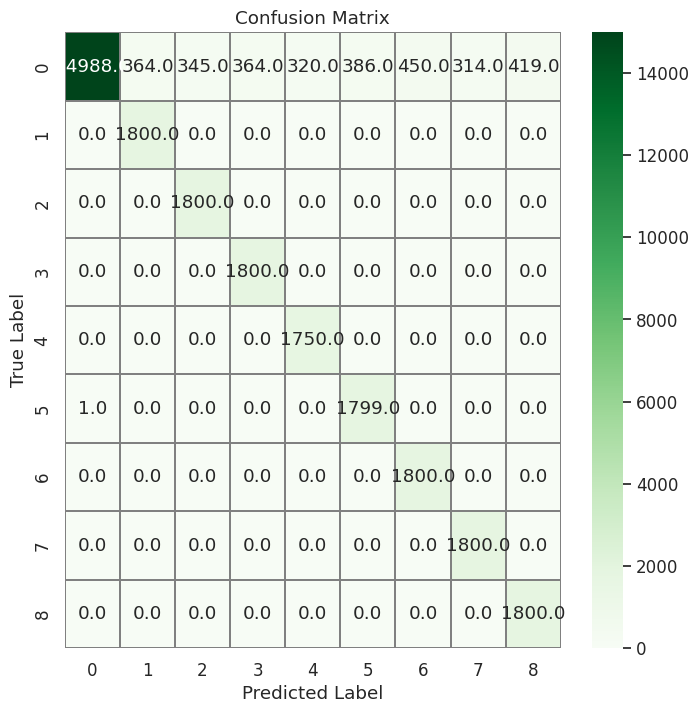

In [32]:
#confusion matrix
confusion_mtx = confusion_matrix(y_train, y_pred_h)

#plot of the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Модель плохо предсказывает 0 класс, попробуем изменить это используя ансамбль моделей.

# Ансамблирование

In [33]:
estimators = [
   ('knn', KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs = -1)),
   ('svc', SVC(kernel='rbf', gamma='scale', C=10000, break_ties=True, decision_function_shape='ovr', max_iter = -1)),
   ('cat', cat_model),
   ('rf', RandomForestClassifier( #метамодель
        n_estimators=10, #количество деревьев в ансамбле
        random_state=42 #датчик генератора случайных чисел
    ))
   ]

clf = StackingClassifier(
   estimators=estimators, final_estimator=LogisticRegression(random_state = 42)
   )
clf.fit(X_train_c , np.ravel(y_train))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('knn',
                                KNeighborsClassifier(n_jobs=-1, n_neighbors=10,
                                                     weights='distance')),
                               ('svc', SVC(C=10000, break_ties=True)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7b8404486620>),
                               ('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

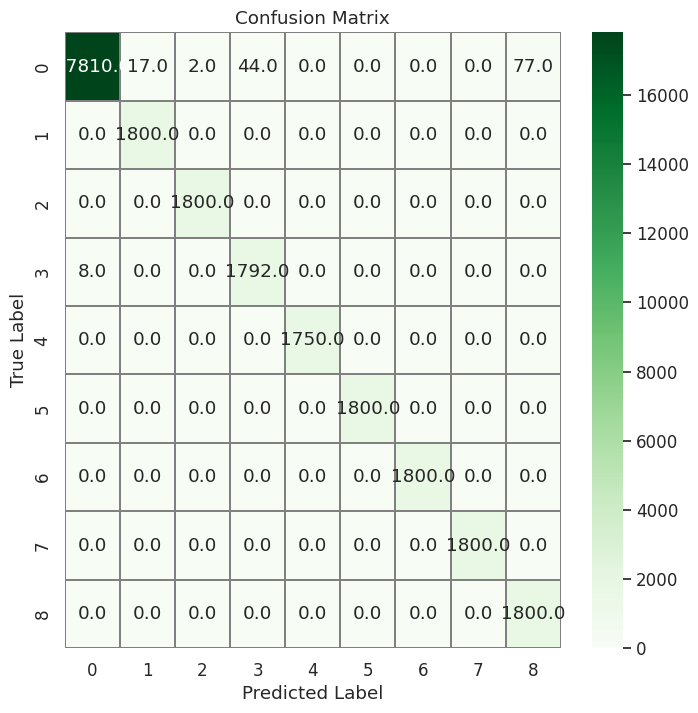

In [34]:
# сделаем предсказание на обучающей выборке
y_pred_h = clf.predict(X_train_c)

#confusion matrix
confusion_mtx = confusion_matrix(y_train, y_pred_h)

#plot of the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Ансамбль моделей лучше предсказывает 0 класс

In [35]:
# Получаем мета-признаки из тренировочных данных
meta_data = clf.transform(X_train_c)
# Создаем DataFrame
meta_df = pd.DataFrame(
    meta_data #содержимое таблицы
    # columns=['meta_feature1', 'meta_feature2','meta_feature3'] #название столбцов
)
meta_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.321298,...,0.002160,0.9,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.320335,...,0.003358,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.322247,...,0.002400,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.320278,...,0.007364,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.321691,...,0.003330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Сделаем предсказание на тестовой выборке

In [37]:
# подготовим тестовые данные, нормализуем и стандартизируем их
X_test.drop(columns=[0,6,24,25,26], inplace=True)
X_test_c = RobustScaler().fit_transform(X_test)
X_test_c = StandardScaler().fit_transform(X_test_c)
# сделаем предсказание классов на тестовой выборке
y_pred = clf.predict(X_test_c)

### Переход от исходного вида к kaggle

In [38]:
y_test = []
for idx, arr in zip(X_test_index, y_pred):
    series = pd.Series(arr)
    series.index = [f"{idx}" for i in series.index]
    y_test.append(series)

y_test = pd.concat(y_test)
y_test = y_test.reset_index()
y_test.columns = ["sample-timestep", "class"]
# отсортируем данные в соответствии с требованиями соревнования
y_test[['sample_id', 'time']] = y_test['sample-timestep'].str.split(pat="-", n=1, expand=True).astype(int)
y_test.sort_values(by=['sample_id', 'time'],inplace=True)
y_test.drop(columns=['sample_id','time'], inplace=True)
y_test.reset_index(drop=True, inplace = True)
y_test.head(3)

,sample-timestep,class
0,0-0,4
1,0-1,4
2,0-2,4


In [39]:
y_test['sample-timestep'] = y_sub['sample-timestep']
y_test.head(3)

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4


Структура индекса совпадает с образцом

In [40]:
# сохраним результат для отправки на платформу Kaggle
y_test.to_csv('./y_test_predicted.csv', index=False)

# Визуализация результата моделирования

In [41]:
# подготовим данные
y_test[['sample_id', 'timestep']] = y_test['sample-timestep'].str.split(pat='-',n=1, expand=True).astype(int)
y_test = y_test.pivot(index='sample_id', columns='timestep', values='class')
y_test_index = y_test.index
y_test = y_test.sort_index() # на всякий случай
y_test = y_test.values

Изменяя параметр i можно увидеть классифицированный результат i-того измерения положения руки оператора

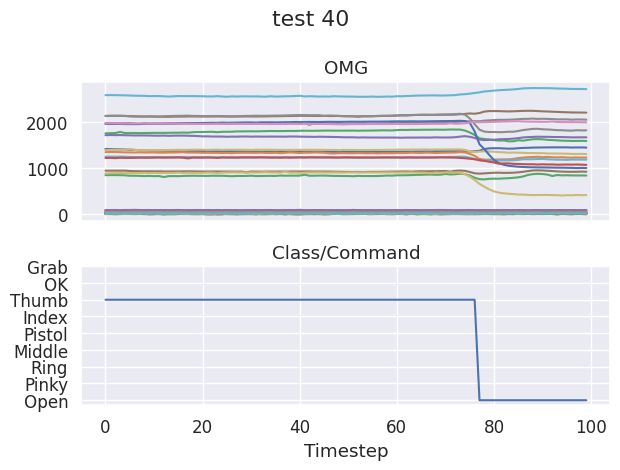

In [44]:
i = 40

fig, axx = plt.subplots(2, 1, sharex=True)

axx[0].plot(X_test_3d[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_test[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'test {i}')

plt.tight_layout()

## Результат:
В процессе данной работы была создана модель, классифицирующая положения руки оператора.